In [1]:
import numpy as np
import g2o 
from collections import defaultdict

pixel_noise = 1.0  # noise in image pixel space (default: 1.0)
outlier_ratio = 0.0  # probability of spuroius observation  (default: 0.0)
robust_kernel = True  # use robust kernel
seed = 0

In [2]:
if seed > 0:
    np.random.seed(seed)

In [3]:
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

focal_length = 1000
principal_point = (320, 240)
cam = g2o.CameraParameters(focal_length, principal_point, 0)
cam.set_id(0)
optimizer.add_parameter(cam)

true_points = np.hstack([
    np.random.random((500, 1)) * 3 - 1.5,
    np.random.random((500, 1)) - 0.5,
    np.random.random((500, 1)) + 3])


true_poses = []
num_pose = 15
for i in range(num_pose):
    # pose here means transform points from world coordinates to camera coordinates
    pose = g2o.SE3Quat(np.identity(3), [i*0.04-1, 0, 0])  # R, t, camera moves along x axis from -1 to -0.43999999999999995
    true_poses.append(pose)

    v_se3 = g2o.VertexSE3Expmap()
    v_se3.set_id(i)
    v_se3.set_estimate(pose)
    if i < 2:
        v_se3.set_fixed(True)
    optimizer.add_vertex(v_se3)


point_id = num_pose
inliers = dict()
sse = defaultdict(float)
vertices_before_optimization = []

for i, point in enumerate(true_points):
    visible = []
    for j, pose in enumerate(true_poses):
        z = cam.cam_map(pose * point)
        if 0 <= z[0] < 640 and 0 <= z[1] < 480:
            visible.append((j, z))
    if len(visible) < 2:
        continue

    vp = g2o.VertexSBAPointXYZ()
    vp.set_id(point_id)
    vp.set_marginalized(True)
    vp.set_estimate(point + np.random.randn(3))
    optimizer.add_vertex(vp)

    inlier = True
    for j, z in visible:
        if np.random.random() < outlier_ratio:
            inlier = False
            z = np.random.random(2) * [640, 480]
        z += np.random.randn(2) * pixel_noise

        edge = g2o.EdgeProjectXYZ2UV()
        edge.set_vertex(0, vp)
        edge.set_vertex(1, optimizer.vertex(j))
        edge.set_measurement(z)
        edge.set_information(np.identity(2))
        if robust_kernel:
            edge.set_robust_kernel(g2o.RobustKernelHuber())
            #edge.set_robust_kernel(g2o.RobustKernelHuber(np.sqrt(5.991)))  # 95% CI

        edge.set_parameter_id(0, 0)
        optimizer.add_edge(edge)

    if inlier:
        inliers[point_id] = i
        error = vp.estimate() - true_points[i]
        sse[0] += np.sum(error**2)
        vertices_before_optimization.append(np.copy(vp.estimate()))
    point_id += 1

In [4]:
print('num vertices:', len(optimizer.vertices()))
print('num edges:', len(optimizer.edges()))

num vertices: 374
num edges: 4760


In [5]:
print('Performing full BA:')
optimizer.initialize_optimization()
optimizer.set_verbose(True)
optimizer.optimize(10)

vertices_after_optimization = []
for i in inliers:
    vp = optimizer.vertex(i)
    error = vp.estimate() - true_points[inliers[i]]
    sse[1] += np.sum(error**2)
    vertices_after_optimization.append(np.copy(vp.estimate()))
    
vertices_before_optimization = np.stack(vertices_before_optimization)
vertices_after_optimization = np.stack(vertices_after_optimization)

print('\nRMSE (inliers only):')
print('before optimization:', np.sqrt(sse[0] / len(inliers)))
print('after  optimization:', np.sqrt(sse[1] / len(inliers)))

Performing full BA:

RMSE (inliers only):
before optimization: 1.7546135859026535
after  optimization: 0.9186635479472811


In [11]:
for pose in true_poses:
    R = np.copy(pose.to_homogeneous_matrix()[0:3, 0:3])
    t = np.copy(pose.to_homogeneous_matrix()[0:3, 3])
    print(R, t)
    
for i in range(len(true_poses)):
    vp = optimizer.vertex(i)
    se3quat = vp.estimate()
    R = np.copy(se3quat.to_homogeneous_matrix()[0:3, 0:3])
    t = np.copy(se3quat.to_homogeneous_matrix()[0:3, 3])
    print(R, t)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-1.  0.  0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.96  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.92  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.88  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.84  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.8  0.   0. ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.76  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.72  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.68  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.64  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.6  0.   0. ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.56  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.52  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.48  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.44  0.    0.  ]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-1.  0.  0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [-0.96  0.    0.  ]
[[ 9.99949985e-01  1.39592452e-03  9.90350962e-03

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

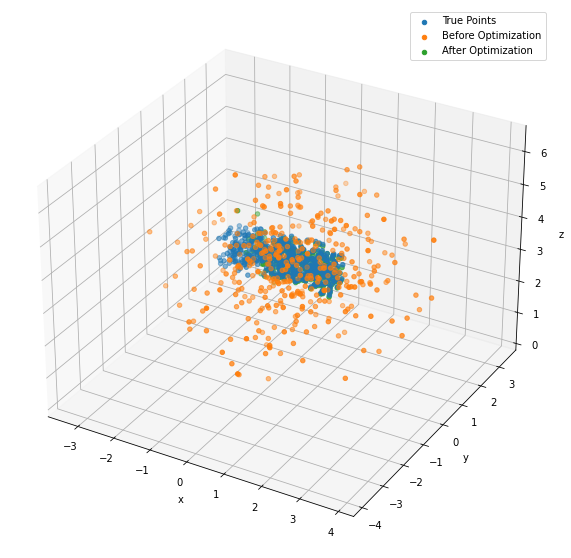

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true_points[:, 0], true_points[:, 1], true_points[:, 2])
ax.scatter(vertices_before_optimization[:, 0], vertices_before_optimization[:, 1], vertices_before_optimization[:, 2])
ax.scatter(vertices_after_optimization[:, 0], vertices_after_optimization[:, 1], vertices_after_optimization[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(["True Points", "Before Optimization", "After Optimization"])
plt.show()

### Run in loop

In [16]:
import numpy as np
import g2o 
from collections import defaultdict


def run():
    pixel_noise = 1.0  # noise in image pixel space (default: 1.0)
    outlier_ratio = 0.0  # probability of spuroius observation  (default: 0.0)
    robust_kernel = True  # use robust kernel
    seed = 1
    
    if seed > 0:
        np.random.seed(seed)
        
    optimizer = g2o.SparseOptimizer()
    solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
    solver = g2o.OptimizationAlgorithmLevenberg(solver)
    optimizer.set_algorithm(solver)

    focal_length = 1000
    principal_point = (320, 240)
    cam = g2o.CameraParameters(focal_length, principal_point, 0)
    cam.set_id(0)
    optimizer.add_parameter(cam)

    true_points = np.hstack([
        np.random.random((500, 1)) * 3 - 1.5,
        np.random.random((500, 1)) - 0.5,
        np.random.random((500, 1)) + 3])


    true_poses = []
    num_pose = 15
    for i in range(num_pose):
        # pose here means transform points from world coordinates to camera coordinates
        pose = g2o.SE3Quat(np.identity(3), [i*0.04-1, 0, 0])  # R, t, camera moves along x axis from -1 to -0.43999999999999995
        true_poses.append(pose)

        v_se3 = g2o.VertexSE3Expmap()
        v_se3.set_id(i)
        v_se3.set_estimate(pose)
        if i < 2:
            v_se3.set_fixed(True)
        optimizer.add_vertex(v_se3)


    point_id = num_pose
    inliers = dict()
    sse = defaultdict(float)
    vertices_before_optimization = []

    for i, point in enumerate(true_points):
        visible = []
        for j, pose in enumerate(true_poses):
            z = cam.cam_map(pose * point)
            if 0 <= z[0] < 640 and 0 <= z[1] < 480:
                visible.append((j, z))
        if len(visible) < 2:
            continue

        vp = g2o.VertexSBAPointXYZ()
        vp.set_id(point_id)
        vp.set_marginalized(True)
        vp.set_estimate(point + np.random.randn(3))
        optimizer.add_vertex(vp)

        inlier = True
        for j, z in visible:
            if np.random.random() < outlier_ratio:
                inlier = False
                z = np.random.random(2) * [640, 480]
            z += np.random.randn(2) * pixel_noise

            edge = g2o.EdgeProjectXYZ2UV()
            edge.set_vertex(0, vp)
            edge.set_vertex(1, optimizer.vertex(j))
            edge.set_measurement(z)
            edge.set_information(np.identity(2))
            if robust_kernel:
                edge.set_robust_kernel(g2o.RobustKernelHuber())
                #edge.set_robust_kernel(g2o.RobustKernelHuber(np.sqrt(5.991)))  # 95% CI

            edge.set_parameter_id(0, 0)
            optimizer.add_edge(edge)

        if inlier:
            inliers[point_id] = i
            error = vp.estimate() - true_points[i]
            sse[0] += np.sum(error**2)
            vertices_before_optimization.append(np.copy(vp.estimate()))
        point_id += 1
        
    print('Performing full BA:')
    optimizer.initialize_optimization()
    optimizer.set_verbose(True)
    optimizer.optimize(10)

    vertices_after_optimization = []
    for i in inliers:
        vp = optimizer.vertex(i)    
        error = vp.estimate() - true_points[inliers[i]]
        sse[1] += np.sum(error**2)
        vertices_after_optimization.append(np.copy(vp.estimate()))

    vertices_before_optimization = np.stack(vertices_before_optimization)
    vertices_after_optimization = np.stack(vertices_after_optimization)

    print('\nRMSE (inliers only):')
    print('before optimization:', np.sqrt(sse[0] / len(inliers)))
    print('after  optimization:', np.sqrt(sse[1] / len(inliers)))
    
    sse_before = np.sqrt(sse[0] / len(inliers))
    sse_after = np.sqrt(sse[1] / len(inliers))
    return sse_before, sse_after

In [17]:
import numpy as np
sses_before = []
sses_after = []
for _ in range(10):
    sse_before, sse_after = run()
    sses_before.append(sse_before)
    sses_after.append(sse_after)

Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization: 0.194584680954
Performing full BA:

RMSE (inliers only):
before optimization: 1.70051700815
after  optimization

In [18]:
print(np.mean(sses_before), np.std(sses_before))
print(np.mean(sses_after), np.std(sses_after))

1.70051700815 0.0
0.194584680954 0.0


(0, 5)

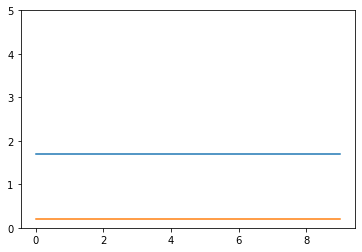

In [19]:
import matplotlib.pyplot as plt
plt.plot(sses_before)
plt.plot(sses_after)
plt.ylim([0, 5])